Stage 1 – Dataset Setup & Extraction

In [1]:
# ==============================
# STEP 2: Upload and Extract .tar file
# ==============================
# If you manually upload via Colab "Files" panel, adjust path accordingly
import tarfile

tar_path = "/content/Capture24.tar.gz"  # <-- replace with your uploaded filename
extract_path = "/content/capture24_data"

with tarfile.open(tar_path, "r") as tar:
    tar.extractall(path=extract_path)

print("Files extracted to:", extract_path)

# ==============================
# STEP 3: Inspect extracted files
# ==============================
import os

for root, dirs, files in os.walk(extract_path):
    for file in files[:10]:  # show first 10 files
        print(os.path.join(root, file))


/tmp/ipython-input-2408937114.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


Files extracted to: /content/capture24_data
/content/capture24_data/WISDM_ar_v1.1/readme.txt
/content/capture24_data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
/content/capture24_data/WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt
/content/capture24_data/WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
/content/capture24_data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt


Stage 2 – Data Loading & Cleaning

In [2]:
import pandas as pd

file_path = os.path.join(extract_path, "/content/capture24_data/capture24.1/capture24.1_raw.txt")

# Define columns (6 columns in raw WISDM)
cols = ['user', 'activity', 'timestamp', 'x', 'y', 'z']

# Read CSV properly as comma-separated
data = pd.read_csv(file_path, header=None, names=cols, sep=",", on_bad_lines="skip")

# Drop rows with NaN
data = data.dropna().reset_index(drop=True)

print("Shape of dataset:", data.shape)
print(data.head())

print("Unique activities:", data['activity'].unique())


Shape of dataset: (1086465, 6)
   user activity       timestamp         x          y             z
0    33  Jogging  49105962326000 -0.694638  12.680544   0.50395286;
1    33  Jogging  49106062271000  5.012288  11.264028   0.95342433;
2    33  Jogging  49106112167000  4.903325  10.882658  -0.08172209;
3    33  Jogging  49106222305000 -0.612916  18.496431    3.0237172;
4    33  Jogging  49106332290000 -1.184970  12.108489     7.205164;
Unique activities: ['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


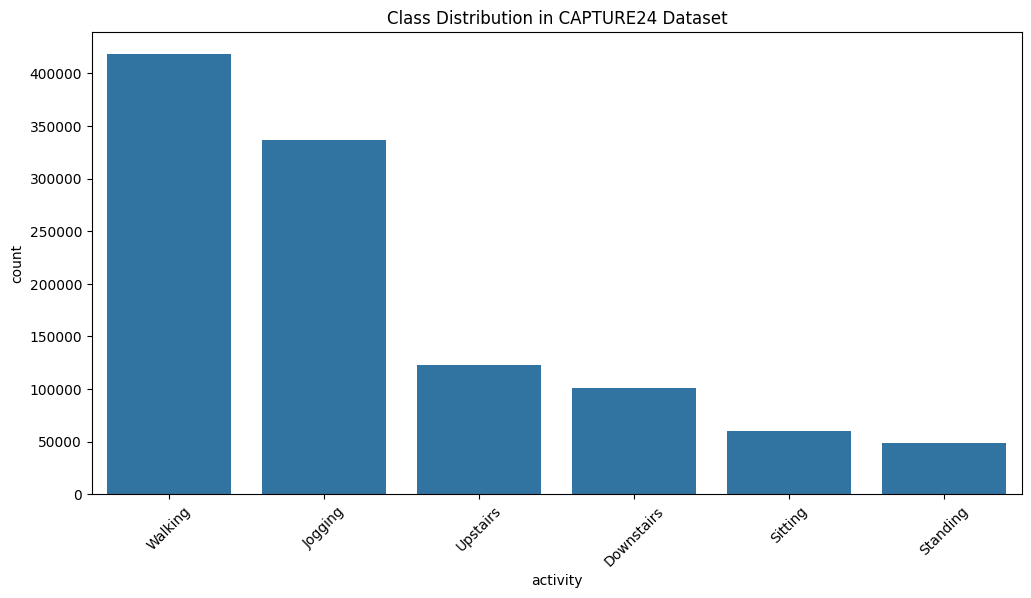

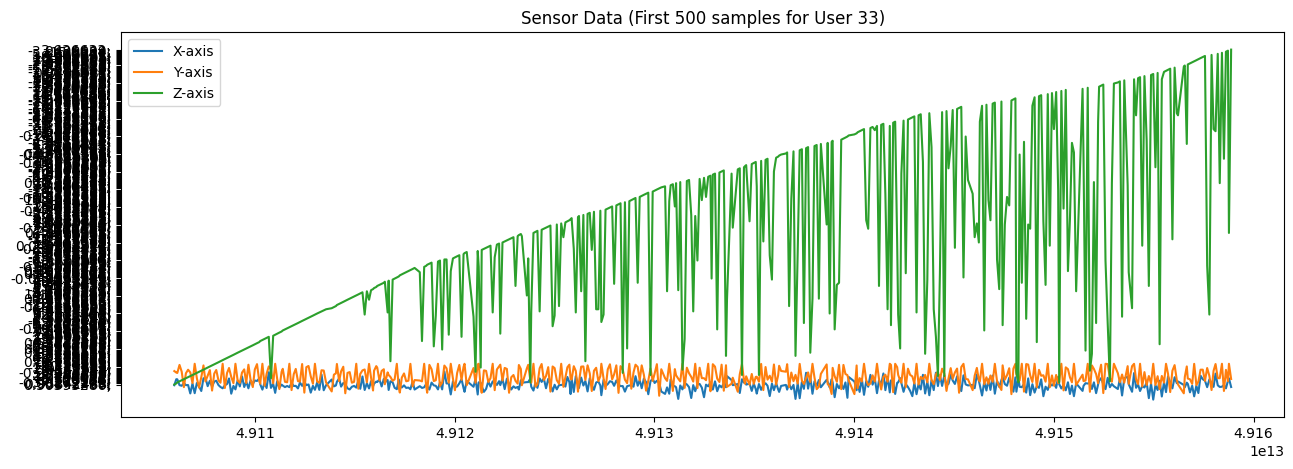

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Activity distribution
plt.figure(figsize=(12,6))
sns.countplot(x="activity", data=data, order=data['activity'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Class Distribution in CAPTURE24 Dataset")
plt.show()

# Plot one sample user
sample_user = data[data['user']==33].head(500)  # pick user 33 as example

plt.figure(figsize=(15,5))
plt.plot(sample_user['timestamp'], sample_user['x'], label="X-axis")
plt.plot(sample_user['timestamp'], sample_user['y'], label="Y-axis")
plt.plot(sample_user['timestamp'], sample_user['z'], label="Z-axis")
plt.legend()
plt.title("Sensor Data (First 500 samples for User 33)")
plt.show()


Stage 3 – Preprocessing & Sliding Windows

After cleaning: (1086465, 6)
Users: 36 | Activities: 6
Activities sample: ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
Windowed X: (10238, 200, 3) | labels: (10238,)
Walking       4086
Jogging       3263
Upstairs      1045
Downstairs     832
Sitting        563
Standing       449
Name: count, dtype: int64
Encoded classes: [np.str_('Downstairs'), np.str_('Jogging'), np.str_('Sitting'), np.str_('Standing'), np.str_('Upstairs'), np.str_('Walking')]
Splits:
 Train: (6552, 200, 3) (6552,)
 Val  : (1638, 200, 3) (1638,)
 Test : (2048, 200, 3) (2048,)
✅ Saved arrays & label encoder to: /content/capture24_data/processed


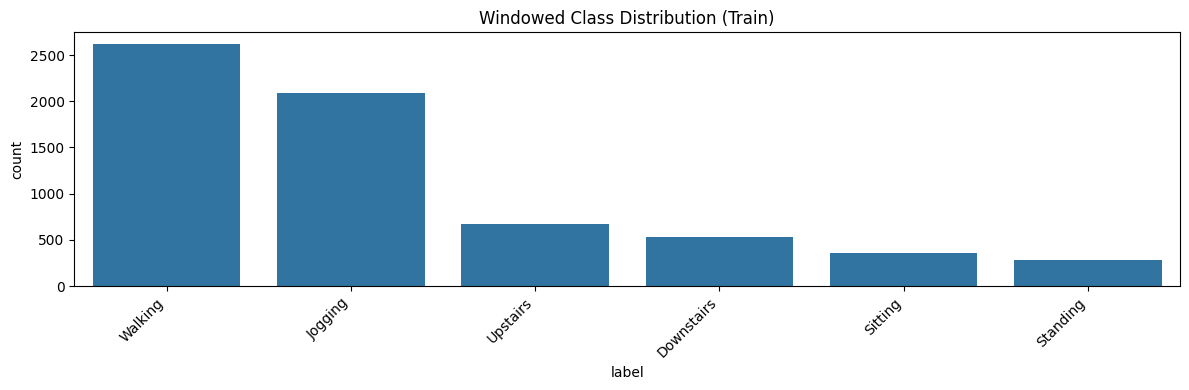

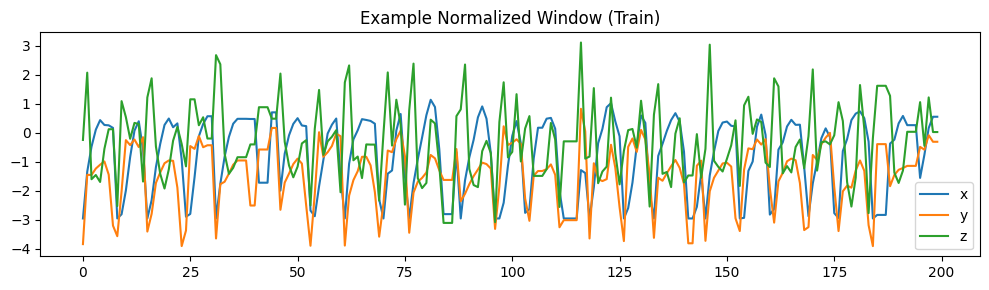

In [4]:
# ==============================
# STAGE 3: Preprocessing + Sliding Window Segmentation (WISDM)
# ==============================
import os, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# -------- Config --------
# Use your extraction root if defined; otherwise default:
try:
    SAVE_ROOT = extract_path
except NameError:
    SAVE_ROOT = "/content/capture24_data"

SAVE_DIR = os.path.join(SAVE_ROOT, "processed")
os.makedirs(SAVE_DIR, exist_ok=True)

WINDOW_SIZE = 200         # timesteps per window
OVERLAP     = 0.5         # 50% overlap
STEP        = max(1, int(WINDOW_SIZE * (1 - OVERLAP)))
MIN_SAMPLES = WINDOW_SIZE # drop activity runs shorter than a window
SEED        = 42

# -------- 3.1 Start from Stage-2 DataFrame --------
if "data" not in globals():
    raise RuntimeError("Stage 2 'data' DataFrame not found. Please run Stage 1–2 first.")
df = data.copy()

# -------- 3.2 Clean numeric columns robustly --------
# Some cells contain stray chars like '-2.03;'. Strip everything except digits, sign, dot, exponent.
def to_numeric_strict(series: pd.Series):
    s = series.astype(str).str.replace(r'[^0-9eE\-\.+]', '', regex=True)
    return pd.to_numeric(s, errors='coerce')

for col in ["timestamp", "x", "y", "z"]:
    df[col] = to_numeric_strict(df[col])

# Tidy activities (strip spaces, keep as string)
df["activity"] = df["activity"].astype(str).str.strip()

# Drop any remaining NaNs
df = df.dropna(subset=["user", "activity", "timestamp", "x", "y", "z"]).reset_index(drop=True)

# Sort for temporal consistency within each user
df = df.sort_values(["user", "timestamp"]).reset_index(drop=True)

print("After cleaning:", df.shape)
print("Users:", df["user"].nunique(), "| Activities:", df["activity"].nunique())
print("Activities sample:", sorted(df["activity"].unique())[:12])

# -------- 3.3 Standardize features (global scaler) --------
scaler = StandardScaler()
df[["x","y","z"]] = scaler.fit_transform(df[["x","y","z"]])

# -------- 3.4 Make overlapping windows within contiguous (user, activity) blocks --------
X_windows, y_labels, meta = [], [], []

def make_windows_block(arr_xyz, label, user_id, start_idx_global):
    N = len(arr_xyz)
    for start in range(0, N - WINDOW_SIZE + 1, STEP):
        end = start + WINDOW_SIZE
        win = arr_xyz[start:end]  # (WINDOW_SIZE, 3)
        if len(win) == WINDOW_SIZE:
            X_windows.append(win)
            y_labels.append(label)
            meta.append({
                "user": user_id,
                "start_row": int(start_idx_global + start),
                "end_row": int(start_idx_global + end),
                "label": label
            })

# Iterate per user, then split into contiguous activity runs
for user_id, g in df.groupby("user", sort=False):
    acts = g["activity"].values
    vals = g[["x","y","z"]].values
    idxs = g.index.values

    if len(g) < MIN_SAMPLES:
        continue

    prev = acts[0]
    run_start = 0
    for i in range(1, len(g)):
        if acts[i] != prev:
            run_end = i
            run_len = run_end - run_start
            if run_len >= MIN_SAMPLES:
                block = vals[run_start:run_end]
                make_windows_block(block, prev, user_id, start_idx_global=idxs[run_start])
            # start new run
            prev = acts[i]
            run_start = i
    # flush last run
    run_end = len(g)
    run_len = run_end - run_start
    if run_len >= MIN_SAMPLES:
        block = vals[run_start:run_end]
        make_windows_block(block, prev, user_id, start_idx_global=idxs[run_start])

X = np.asarray(X_windows)                 # (N_windows, WINDOW_SIZE, 3)
labels_raw = np.asarray(y_labels)         # (N_windows,)
meta_df = pd.DataFrame(meta)

if X.size == 0:
    raise RuntimeError("No windows were created. Consider reducing WINDOW_SIZE or check data integrity.")

print("Windowed X:", X.shape, "| labels:", labels_raw.shape)
print(pd.Series(labels_raw).value_counts().head(20))

# -------- 3.5 Encode labels --------
le = LabelEncoder()
y = le.fit_transform(labels_raw)
classes = list(le.classes_)
print("Encoded classes:", classes)

# -------- 3.6 Stratified Train/Val/Test Split --------
# 80% temp / 20% test, then of the 80% → 80/20 train/val
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.20, stratify=y_tmp, random_state=SEED
)
print("Splits:")
print(" Train:", X_train.shape, y_train.shape)
print(" Val  :", X_val.shape,   y_val.shape)
print(" Test :", X_test.shape,  y_test.shape)

# -------- 3.7 Save artefacts --------
np.save(os.path.join(SAVE_DIR, "X_train.npy"), X_train)
np.save(os.path.join(SAVE_DIR, "X_val.npy"),   X_val)
np.save(os.path.join(SAVE_DIR, "X_test.npy"),  X_test)
np.save(os.path.join(SAVE_DIR, "y_train.npy"), y_train)
np.save(os.path.join(SAVE_DIR, "y_val.npy"),   y_val)
np.save(os.path.join(SAVE_DIR, "y_test.npy"),  y_test)

with open(os.path.join(SAVE_DIR, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)

# Save a distribution table for reporting
dist_train = pd.Series(y_train).value_counts().rename("count").rename_axis("class_id").reset_index()
dist_train["label"] = dist_train["class_id"].map({i:c for i,c in enumerate(classes)})
dist_train.sort_values("count", ascending=False).to_csv(os.path.join(SAVE_DIR, "class_distribution_train.csv"), index=False)

print("✅ Saved arrays & label encoder to:", SAVE_DIR)

# -------- 3.8 Visuals: windowed class distribution + example window --------
plt.figure(figsize=(12,4))
order = dist_train.sort_values("count", ascending=False)["label"].tolist()
sns.barplot(x="label", y="count", data=dist_train, order=order)
plt.xticks(rotation=45, ha="right")
plt.title("Windowed Class Distribution (Train)")
plt.tight_layout()
plt.show()

if len(X_train) > 0:
    ex = X_train[0]
    plt.figure(figsize=(10,3))
    plt.plot(ex[:,0], label="x")
    plt.plot(ex[:,1], label="y")
    plt.plot(ex[:,2], label="z")
    plt.legend()
    plt.title("Example Normalized Window (Train)")
    plt.tight_layout()
    plt.show()

Stage 4 – Model Development (CNN + BiLSTM)

Train: (6552, 200, 3) (6552,)
Val  : (1638, 200, 3) (1638,)
Test : (2048, 200, 3) (2048,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,982 (621.02 KB)

 Trainable params: 158,598 (619.52 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6407 - loss: 1.0358
Epoch 1: val_loss improved from inf to 0.76052, saving model to /content/capture24_data/processed/cnn_bilstm_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 317ms/step - accuracy: 0.6428 - loss: 1.0303 - val_accuracy: 0.7759 - val_loss: 0.7605
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8519 - loss: 0.4263
Epoch 2: val_loss did not improve from 0.76052
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 311ms/step - accuracy: 0.8522 - loss: 0.4254 - val_accuracy: 0.5104 - val_loss: 1.4719
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8933 - loss: 0.2876
Epoch 3: val_loss did not improve from 0.76052
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - accuracy: 0.8934 - loss: 0.2872 - val_accuracy: 0.4615 - val_loss: 2.1423
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9197 - loss: 0.2121
Epoch 4: val_loss did not improve from 0.76052
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 303ms/step - accuracy: 0.9198 - loss: 0.2121 - val_accuracy: 0.4707 - val_loss: 2.1560
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9436 - loss: 0.1563
Epoch 5: val_loss did not improve from 0.76

52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step - accuracy: 0.9660 - loss: 0.0990 - val_accuracy: 0.8938 - val_loss: 0.3388
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9749 - loss: 0.0713
Epoch 8: val_loss improved from 0.33880 to 0.13943, saving model to /content/capture24_data/processed/cnn_bilstm_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 303ms/step - accuracy: 0.9749 - loss: 0.0712 - val_accuracy: 0.9615 - val_loss: 0.1394
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9802 - loss: 0.0610
Epoch 9: val_loss did not improve from 0.13943
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 309ms/step - accuracy: 0.9802 - loss: 0.0610 - val_accuracy: 0.9524 - val_loss: 0.1484
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9796 - loss: 0.0655
Epoch 10: val_loss improved from 0.13943 to 0.05570, saving model to /content/capture24_data/processed/cnn_bilstm_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 311ms/step - accuracy: 0.9797 - loss: 0.0653 - val_accuracy: 0.9811 - val_loss: 0.0557
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9835 - loss: 0.0577
Epoch 11: val_loss improved from 0.05570 to 0.04061, saving model to /content/capture24_data/processed/cnn_bilstm_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 307ms/step - accuracy: 0.9835 - loss: 0.0578 - val_accuracy: 0.9866 - val_loss: 0.0406
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9837 - loss: 0.0544
Epoch 12: val_loss did not improve from 0.04061
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 317ms/step - accuracy: 0.9837 - loss: 0.0544 - val_accuracy: 0.9835 - val_loss: 0.0451
Epoch 13/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9880 - loss: 0.0393
Epoch 13: val_loss did not improve from 0.04061
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 308ms/step - accuracy: 0.9880 - loss: 0.0392 - val_accuracy: 0.9792 - val_loss: 0.0737
Epoch 14/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9838 - loss: 0.0540
Epoch 14: val_loss improved from 0.04061 to 0.03568, saving model to /content/capture24_data/processed/cnn_bilstm_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - accuracy: 0.9838 - loss: 0.0539 - val_accuracy: 0.9908 - val_loss: 0.0357
Epoch 15/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9918 - loss: 0.0260
Epoch 15: val_loss did not improve from 0.03568
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 301ms/step - accuracy: 0.9918 - loss: 0.0260 - val_accuracy: 0.9866 - val_loss: 0.0403
Epoch 16/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9869 - loss: 0.0396
Epoch 16: val_loss did not improve from 0.03568
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 309ms/step - accuracy: 0.9869 - loss: 0.0396 - val_accuracy: 0.9847 - val_loss: 0.0505
Epoch 17/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9922 - loss: 0.0281
Epoch 17: val_loss improved from 0.03568 to 0.02182, saving model to /content/capture24_data/processed/cnn_bilstm_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.9922 - loss: 0.0281 - val_accuracy: 0.9939 - val_loss: 0.0218
Epoch 18/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9933 - loss: 0.0210
Epoch 18: val_loss did not improve from 0.02182
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 301ms/step - accuracy: 0.9933 - loss: 0.0210 - val_accuracy: 0.9908 - val_loss: 0.0250
Epoch 19/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9909 - loss: 0.0405
Epoch 19: val_loss did not improve from 0.02182
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 314ms/step - accuracy: 0.9909 - loss: 0.0404 - val_accuracy: 0.9915 - val_loss: 0.0248
Epoch 20/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9953 - loss: 0.0206
Epoch 20: val_loss did not improve from 0.02182
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step - accuracy: 0.9952 - loss: 0.0209 - val_accuracy: 0.9853 - val_loss: 0.0558
Epoch 21/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9851 - loss: 0.0457
Epoch 21: val_loss improved from 0.0

52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - accuracy: 0.9852 - loss: 0.0454 - val_accuracy: 0.9976 - val_loss: 0.0150
Epoch 22/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9954 - loss: 0.0151
Epoch 22: val_loss improved from 0.01496 to 0.01194, saving model to /content/capture24_data/processed/cnn_bilstm_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - accuracy: 0.9954 - loss: 0.0151 - val_accuracy: 0.9969 - val_loss: 0.0119
Epoch 23/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9957 - loss: 0.0148
Epoch 23: val_loss improved from 0.01194 to 0.01144, saving model to /content/capture24_data/processed/cnn_bilstm_best.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 315ms/step - accuracy: 0.9957 - loss: 0.0147 - val_accuracy: 0.9963 - val_loss: 0.0114
Epoch 24/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9948 - loss: 0.0122
Epoch 24: val_loss did not improve from 0.01144
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step - accuracy: 0.9949 - loss: 0.0122 - val_accuracy: 0.9951 - val_loss: 0.0154
Epoch 25/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9962 - loss: 0.0116
Epoch 25: val_loss did not improve from 0.01144
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 306ms/step - accuracy: 0.9962 - loss: 0.0116 - val_accuracy: 0.9921 - val_loss: 0.0193
Epoch 26/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9921 - loss: 0.0270
Epoch 26: val_loss did not improve from 0.01144
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 300ms/step - accuracy: 0.9921 - loss: 0.0268 - val_accuracy: 0.9890 - val_loss: 0.0313
Epoch 27/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9906 - loss: 0.0260
Epoch 27: val_loss did not improve f

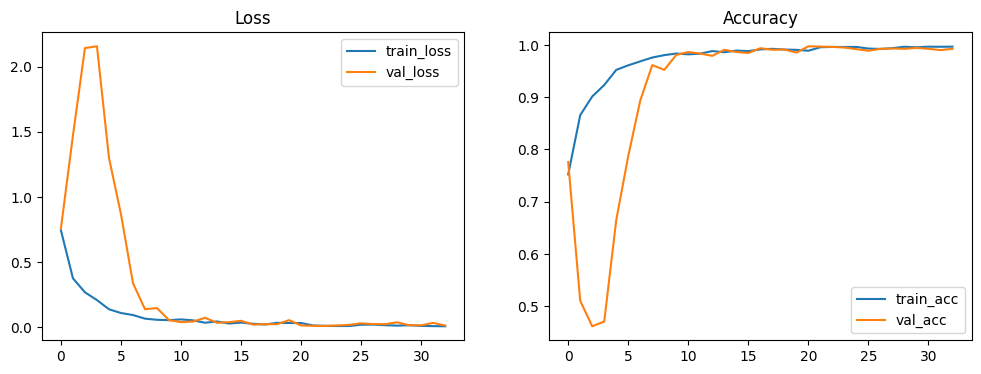

✅ Test Accuracy: 0.992


In [6]:
# ==============================
# STAGE 4: Build & Train CNN + BiLSTM Model
# ==============================
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import os, pickle

# -------- Load Data --------
SAVE_DIR = "/content/capture24_data/processed"   # adjust if different

X_train = np.load(os.path.join(SAVE_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(SAVE_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(SAVE_DIR, "X_test.npy"))
y_train = np.load(os.path.join(SAVE_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(SAVE_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(SAVE_DIR, "y_test.npy"))

with open(os.path.join(SAVE_DIR, "label_encoder.pkl"), "rb") as f:
    le = pickle.load(f)
n_classes = len(le.classes_)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("Test :", X_test.shape,  y_test.shape)

# -------- Model --------
def build_cnn_bilstm(input_shape, n_classes):
    model = models.Sequential([
        layers.Conv1D(64, 5, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),

        layers.Conv1D(128, 5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),

        layers.Bidirectional(layers.LSTM(64, return_sequences=False)),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_cnn_bilstm(X_train.shape[1:], n_classes)
model.summary()

# -------- Training --------
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint(
    os.path.join(SAVE_DIR, "cnn_bilstm_best.h5"),
    monitor="val_loss", save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# -------- Plot Training Curves --------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy")
plt.show()

# -------- Evaluate on Test --------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.3f}")

Stage 4.5 – Model Evaluation

✅ Test Metrics
- Accuracy:        0.9922
- Precision (w):   0.9922
- Recall (w):      0.9922
- F1 (weighted):   0.9922
- F1 (macro):      0.9875
- F1 (micro):      0.9922


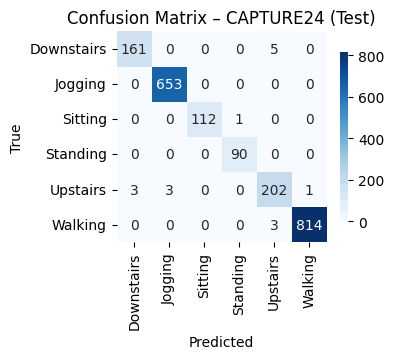

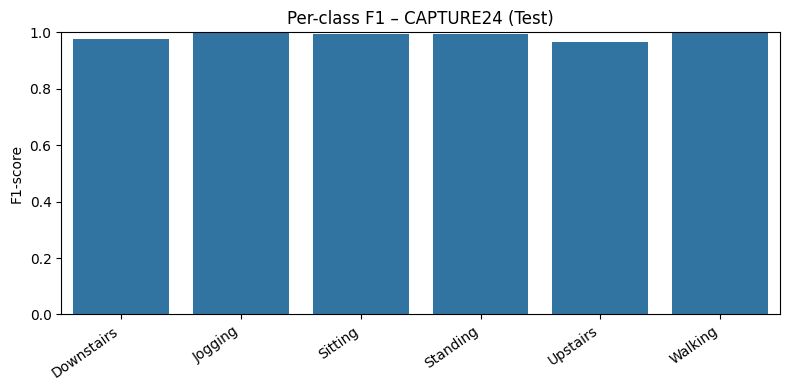

📁 Saved:
- /content/capture24_data/processed/confusion_matrix_test.png
- /content/capture24_data/processed/per_class_f1_test.png
- /content/capture24_data/processed/classification_report_test.csv
- /content/capture24_data/processed/classification_report_test.json
- /content/capture24_data/processed/metrics_summary_test.csv


In [8]:
# ==============================
# STAGE 4.5: Evaluation Plots (Confusion Matrix, Classification Report, Per-class F1)
# ==============================
import os, json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import tensorflow as tf

# -------- Paths --------
SAVE_DIR = "/content/capture24_data/processed"
MODEL_PATH = os.path.join(SAVE_DIR, "cnn_bilstm_best.h5")  # from Stage 4

# -------- Load data & artefacts --------
X_test = np.load(os.path.join(SAVE_DIR, "X_test.npy"))
y_test = np.load(os.path.join(SAVE_DIR, "y_test.npy"))
with open(os.path.join(SAVE_DIR, "label_encoder.pkl"), "rb") as f:
    le = pickle.load(f)
classes = list(le.classes_)

# Load best model
model = tf.keras.models.load_model(MODEL_PATH)

# -------- Predict --------
probs = model.predict(X_test, batch_size=512, verbose=0)
# ensure 2D (N, C)
if probs.ndim == 1:
    probs = probs[:, None]
y_pred = probs.argmax(axis=1)

# -------- Metrics (printed) --------
acc  = accuracy_score(y_test, y_pred)
p_w  = precision_score(y_test, y_pred, average="weighted", zero_division=0)
r_w  = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1_w = f1_score(y_test, y_pred, average="weighted", zero_division=0)
f1_mi = f1_score(y_test, y_pred, average="micro", zero_division=0)
f1_ma = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("✅ Test Metrics")
print(f"- Accuracy:        {acc:.4f}")
print(f"- Precision (w):   {p_w:.4f}")
print(f"- Recall (w):      {r_w:.4f}")
print(f"- F1 (weighted):   {f1_w:.4f}")
print(f"- F1 (macro):      {f1_ma:.4f}")
print(f"- F1 (micro):      {f1_mi:.4f}")

# -------- Classification report (table + files) --------
report_dict = classification_report(
    y_test, y_pred, target_names=classes, output_dict=True, zero_division=0
)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(SAVE_DIR, "classification_report_test.csv"))
with open(os.path.join(SAVE_DIR, "classification_report_test.json"), "w") as f:
    json.dump(report_dict, f, indent=2)

# -------- Confusion Matrix Plot --------
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(classes)))

plt.figure(figsize=(1.0 + 0.5*len(classes), 1.0 + 0.45*len(classes)))  # scale with classes
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=classes, yticklabels=classes,
    cbar_kws={"shrink": .8}
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – CAPTURE24 (Test)")
plt.tight_layout()
cm_path = os.path.join(SAVE_DIR, "confusion_matrix_test.png")
plt.savefig(cm_path, dpi=220)
plt.show()

# -------- Per-class F1 bar chart --------
per_class_f1 = [report_dict[c]["f1-score"] for c in classes]
plt.figure(figsize=(max(8, 0.6*len(classes)), 4))
sns.barplot(x=classes, y=per_class_f1)
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=35, ha="right")
plt.title("Per-class F1 – CAPTURE24 (Test)")
plt.tight_layout()
f1_path = os.path.join(SAVE_DIR, "per_class_f1_test.png")
plt.savefig(f1_path, dpi=220)
plt.show()

# -------- Save also a compact metrics CSV --------
metrics_row = {
    "accuracy": acc, "precision_weighted": p_w, "recall_weighted": r_w,
    "f1_weighted": f1_w, "f1_macro": f1_ma, "f1_micro": f1_mi
}
pd.DataFrame([metrics_row]).to_csv(os.path.join(SAVE_DIR, "metrics_summary_test.csv"), index=False)

print("📁 Saved:")
print("-", cm_path)
print("-", f1_path)
print("-", os.path.join(SAVE_DIR, "classification_report_test.csv"))
print("-", os.path.join(SAVE_DIR, "classification_report_test.json"))
print("-", os.path.join(SAVE_DIR, "metrics_summary_test.csv"))

Stage 4.6 – Predictions Export

In [9]:
# ==============================
# STAGE 4.6: Export Predictions CSV
# ==============================
import pandas as pd
import numpy as np
import os
import pickle
import tensorflow as tf

# -------- Paths --------
SAVE_DIR = "/content/capture24_data/processed"
MODEL_PATH = os.path.join(SAVE_DIR, "cnn_bilstm_best.h5")

# Load data & artefacts
X_test = np.load(os.path.join(SAVE_DIR, "X_test.npy"))
y_test = np.load(os.path.join(SAVE_DIR, "y_test.npy"))
with open(os.path.join(SAVE_DIR, "label_encoder.pkl"), "rb") as f:
    le = pickle.load(f)
classes = list(le.classes_)

# Load model
model = tf.keras.models.load_model(MODEL_PATH)

# -------- Predictions --------
probs = model.predict(X_test, batch_size=512, verbose=0)
if probs.ndim == 1:  # handle binary
    probs = np.vstack([1 - probs, probs]).T

y_pred = probs.argmax(axis=1)
top1_prob = probs.max(axis=1)

# -------- Build DataFrame --------
df_preds = pd.DataFrame({
    "true_label": le.inverse_transform(y_test),
    "pred_label": le.inverse_transform(y_pred),
    "top1_prob": top1_prob
})

# Save
csv_path = os.path.join(SAVE_DIR, "predictions_test.csv")
df_preds.to_csv(csv_path, index=False)

print(f"✅ Saved predictions to {csv_path}")
print(df_preds.head(10))

✅ Saved predictions to /content/capture24_data/processed/predictions_test.csv
  true_label pred_label  top1_prob
0   Upstairs   Upstairs   0.999647
1    Jogging    Jogging   0.999998
2   Upstairs   Upstairs   0.999188
3    Jogging    Jogging   0.999998
4    Walking    Walking   0.999997
5    Jogging    Jogging   0.999999
6    Jogging    Jogging   0.999997
7    Walking    Walking   0.999994
8    Walking    Walking   0.999999
9    Walking    Walking   0.999823


Stage 4.7 – Reliability Analysis

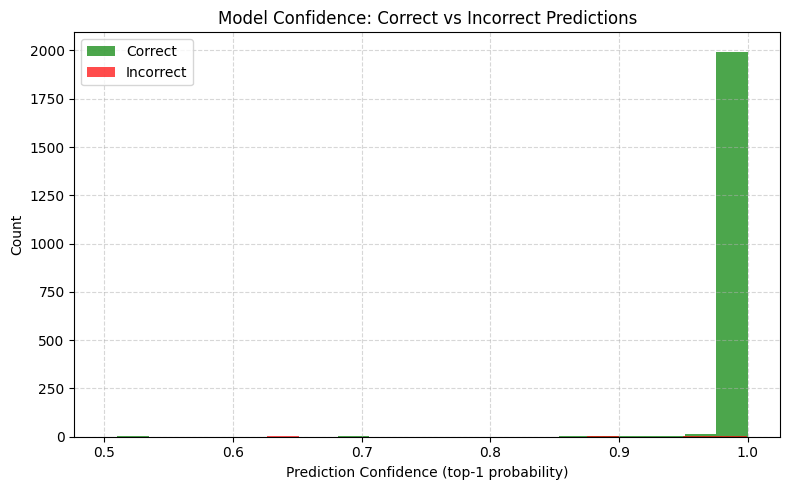

✅ Confidence histogram saved to /content/capture24_data/processed/confidence_histogram.png


In [10]:
# ==============================
# STAGE 4.7: Reliability Visualization
# ==============================
import matplotlib.pyplot as plt

# Mark correct vs incorrect predictions
df_preds["correct"] = df_preds["true_label"] == df_preds["pred_label"]

# ---- Histogram of top-1 probabilities ----
plt.figure(figsize=(8,5))
plt.hist(df_preds[df_preds["correct"]]["top1_prob"], bins=20, alpha=0.7, label="Correct", color="green")
plt.hist(df_preds[~df_preds["correct"]]["top1_prob"], bins=20, alpha=0.7, label="Incorrect", color="red")
plt.xlabel("Prediction Confidence (top-1 probability)")
plt.ylabel("Count")
plt.title("Model Confidence: Correct vs Incorrect Predictions")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

plot_path = os.path.join(SAVE_DIR, "confidence_histogram.png")
plt.savefig(plot_path, dpi=200)
plt.show()

print(f"✅ Confidence histogram saved to {plot_path}")


In [11]:
print("Mean confidence (correct):", df_preds[df_preds["correct"]]["top1_prob"].mean())
print("Mean confidence (incorrect):", df_preds[~df_preds["correct"]]["top1_prob"].mean())

Mean confidence (correct): 0.996834
Mean confidence (incorrect): 0.84110886


Stage 4.8 – Calibration

✅ Calibration metrics — ECE: 0.0058 | MCE: 0.5698
Saved bin table: /content/capture24_data/processed/calibration_bins.csv


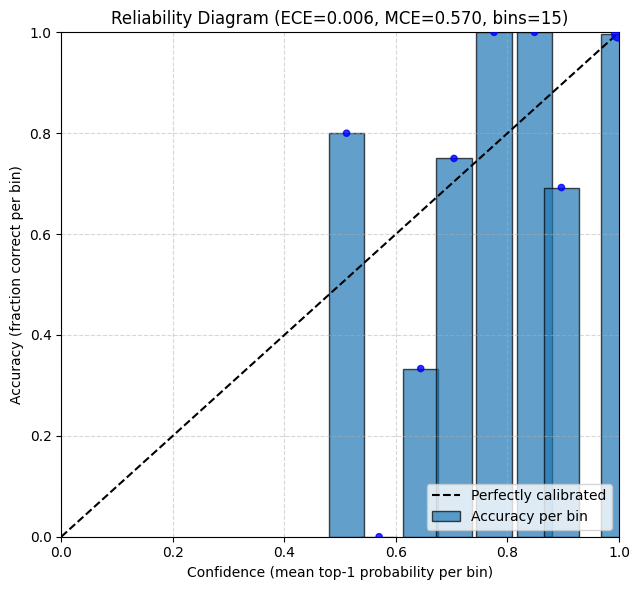

📁 Saved: /content/capture24_data/processed/reliability_diagram.png


In [12]:
# ==============================
# STAGE 4.8: Reliability Diagram + ECE / MCE
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure df_preds exists with columns: true_label, pred_label, top1_prob
assert {"true_label","pred_label","top1_prob"}.issubset(df_preds.columns), "Run Stage 4.6 first."

# Mark correctness
df_preds["correct"] = (df_preds["true_label"] == df_preds["pred_label"])

def reliability_bins(probs, correct, n_bins=15):
    """Compute calibration bins: confidence vs accuracy per bin."""
    probs = np.asarray(probs, dtype=float)
    correct = np.asarray(correct, dtype=bool)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(probs, bins, right=True)
    # put exact 1.0 in last bin
    bin_ids = np.clip(bin_ids, 1, n_bins)

    bin_confs, bin_accs, bin_cnts = [], [], []
    for b in range(1, n_bins+1):
        mask = (bin_ids == b)
        cnt = mask.sum()
        if cnt > 0:
            conf = probs[mask].mean()
            acc  = correct[mask].mean()
        else:
            conf, acc = np.nan, np.nan
        bin_confs.append(conf)
        bin_accs.append(acc)
        bin_cnts.append(cnt)
    return np.array(bin_confs), np.array(bin_accs), np.array(bin_cnts), bins

def ece_mce(probs, correct, n_bins=15):
    """Expected Calibration Error (ECE) and Maximum Calibration Error (MCE)."""
    bin_confs, bin_accs, bin_cnts, bins = reliability_bins(probs, correct, n_bins)
    total = np.sum(bin_cnts)
    weights = np.where(total > 0, bin_cnts / total, 0.0)
    abs_gap = np.abs(bin_accs - bin_confs)
    # ignore empty-bin NaNs
    abs_gap = np.where(np.isnan(abs_gap), 0.0, abs_gap)
    ece = np.sum(weights * abs_gap)
    mce = np.nanmax(abs_gap) if np.any(~np.isnan(abs_gap)) else np.nan
    return ece, mce, bin_confs, bin_accs, bin_cnts, bins

# --- Compute metrics ---
ECE_BINS = 15  # you can try 10, 15, 20
ece, mce, bin_confs, bin_accs, bin_cnts, edges = ece_mce(df_preds["top1_prob"].values,
                                                         df_preds["correct"].values,
                                                         n_bins=ECE_BINS)

print(f"✅ Calibration metrics — ECE: {ece:.4f} | MCE: {mce:.4f}")
calib_df = pd.DataFrame({
    "bin_lower": edges[:-1],
    "bin_upper": edges[1:],
    "count": bin_cnts,
    "conf_mean": bin_confs,
    "acc_mean": bin_accs
})
calib_path_csv = os.path.join(SAVE_DIR, "calibration_bins.csv")
calib_df.to_csv(calib_path_csv, index=False)
print("Saved bin table:", calib_path_csv)

# --- Reliability diagram plot ---
# Use non-empty bins only for the bars
mask = ~np.isnan(bin_accs) & ~np.isnan(bin_confs)
x = bin_confs[mask]
y = bin_accs[mask]
c = bin_cnts[mask]

plt.figure(figsize=(6.5, 6))
# Bars: accuracy per confidence bin (width scaled to bin width)
bin_width = 1.0 / ECE_BINS
plt.bar(x, y, width=bin_width*0.95, edgecolor='black', alpha=0.7, label="Accuracy per bin")

# Diagonal: perfect calibration
plt.plot([0,1], [0,1], '--', color='black', label='Perfectly calibrated')

# Optionally overlay points sized by bin count
sizes = 20 + 80 * (c / (c.max() if c.max() > 0 else 1.0))
plt.scatter(x, y, s=sizes, color='blue', alpha=0.8, zorder=3)

plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Confidence (mean top-1 probability per bin)")
plt.ylabel("Accuracy (fraction correct per bin)")
plt.title(f"Reliability Diagram (ECE={ece:.3f}, MCE={mce:.3f}, bins={ECE_BINS})")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

calib_plot_path = os.path.join(SAVE_DIR, "reliability_diagram.png")
plt.savefig(calib_plot_path, dpi=220)
plt.show()

print("📁 Saved:", calib_plot_path)

🔧 Optimal temperature: 0.901
✅ After calibration — ECE: 0.6159 | MCE: 0.6175


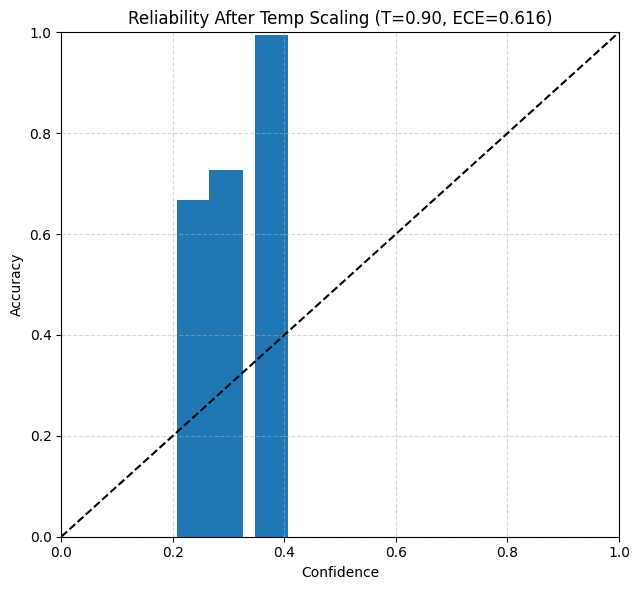

In [13]:
# ==============================
# STAGE 4.9: Temperature Scaling Calibration
# ==============================
import tensorflow as tf
from scipy.optimize import minimize

# --- 1. Load logits on val set (not softmaxed) ---
# You must have X_val, y_val ready
# If only probabilities are available, skip this and use logit = log(p / (1-p)) approx
logits_val = model.predict(X_val, verbose=0)  # raw model output (before softmax if possible)

# If your model already applies softmax, invert to logits
if logits_val.shape[1] == len(le.classes_):  # multi-class
    probs_val = logits_val
    logits_val = np.log(probs_val + 1e-12)   # pseudo-logits
else:
    probs_val = tf.nn.softmax(logits_val).numpy()

# --- 2. Temperature scaling function ---
def softmax_temp(logits, T):
    return tf.nn.softmax(logits / T, axis=1).numpy()

def nll_loss(T):
    probs = softmax_temp(logits_val, T)
    y_true = tf.keras.utils.to_categorical(y_val, num_classes=len(le.classes_))
    # negative log likelihood
    return -np.mean(np.sum(y_true * np.log(probs + 1e-12), axis=1))

# --- 3. Optimize temperature ---
res = minimize(lambda t: nll_loss(t[0]), x0=[1.0], bounds=[(0.5, 5.0)])
T_opt = res.x[0]
print(f"🔧 Optimal temperature: {T_opt:.3f}")

# --- 4. Apply scaling to test set ---
logits_test = model.predict(X_test, verbose=0)
probs_test = softmax_temp(logits_test, T_opt)
preds_test = probs_test.argmax(axis=1)
conf_test  = probs_test.max(axis=1)

# --- 5. Build new df_preds_calib ---
df_preds_calib = pd.DataFrame({
    "true_label": le.inverse_transform(y_test),
    "pred_label": le.inverse_transform(preds_test),
    "top1_prob": conf_test
})
df_preds_calib["correct"] = (df_preds_calib["true_label"] == df_preds_calib["pred_label"])

# --- 6. Recompute ECE & Reliability plot ---
ece_c, mce_c, _, _, _, _ = ece_mce(df_preds_calib["top1_prob"], df_preds_calib["correct"], n_bins=15)
print(f"✅ After calibration — ECE: {ece_c:.4f} | MCE: {mce_c:.4f}")

plt.figure(figsize=(6.5,6))
plt.bar(*reliability_bins(df_preds_calib["top1_prob"], df_preds_calib["correct"], n_bins=15)[:2], width=0.06)
plt.plot([0,1],[0,1],'--',color='black')
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Confidence"); plt.ylabel("Accuracy")
plt.title(f"Reliability After Temp Scaling (T={T_opt:.2f}, ECE={ece_c:.3f})")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "reliability_diagram_temp_scaled.png"), dpi=220)
plt.show()

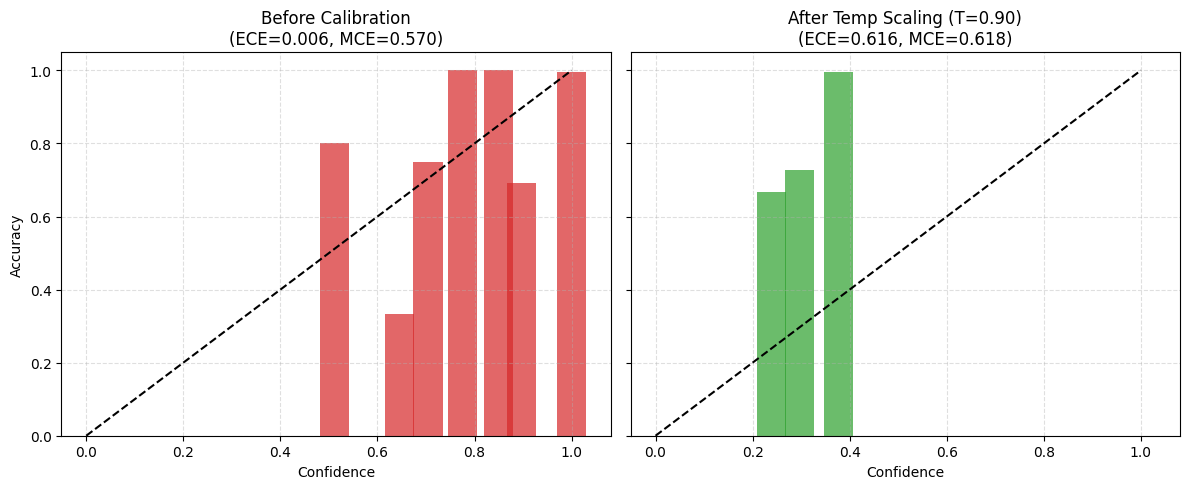

In [14]:
# ==============================
# STAGE 4.10: Side-by-Side Reliability Plot
# ==============================

# Function to compute bin stats
def reliability_bins(conf, correct, n_bins=15):
    bins = np.linspace(0,1,n_bins+1)
    idx  = np.digitize(conf, bins) - 1
    bin_acc, bin_conf, bin_count = [], [], []
    for i in range(n_bins):
        mask = idx==i
        if mask.sum()>0:
            bin_acc.append(correct[mask].mean())
            bin_conf.append(conf[mask].mean())
            bin_count.append(mask.sum())
        else:
            bin_acc.append(0)
            bin_conf.append((bins[i]+bins[i+1])/2)
            bin_count.append(0)
    return np.array(bin_conf), np.array(bin_acc), np.array(bin_count)

# --- Before calibration ---
conf_b, acc_b, count_b = reliability_bins(df_preds["top1_prob"], df_preds["correct"], n_bins=15)

# --- After calibration ---
conf_a, acc_a, count_a = reliability_bins(df_preds_calib["top1_prob"], df_preds_calib["correct"], n_bins=15)

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

# Before
axes[0].bar(conf_b, acc_b, width=0.06, alpha=0.7, color="tab:red")
axes[0].plot([0,1],[0,1],'--',color='black')
axes[0].set_title(f"Before Calibration\n(ECE={ece:.3f}, MCE={mce:.3f})")
axes[0].set_xlabel("Confidence")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True, linestyle="--", alpha=0.4)

# After
axes[1].bar(conf_a, acc_a, width=0.06, alpha=0.7, color="tab:green")
axes[1].plot([0,1],[0,1],'--',color='black')
axes[1].set_title(f"After Temp Scaling (T={T_opt:.2f})\n(ECE={ece_c:.3f}, MCE={mce_c:.3f})")
axes[1].set_xlabel("Confidence")
axes[1].grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "reliability_side_by_side.png"), dpi=250)
plt.show()

In [15]:
# ==============================
# STAGE 4.11: Calibration Metrics Table
# ==============================

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# --- Before calibration metrics ---
acc_b = accuracy_score(df_preds["true_label"], df_preds["pred_label"])
f1_b  = f1_score(df_preds["true_label"], df_preds["pred_label"], average="macro")
prec_b = precision_score(df_preds["true_label"], df_preds["pred_label"], average="macro")
rec_b  = recall_score(df_preds["true_label"], df_preds["pred_label"], average="macro")

# --- After calibration metrics ---
acc_a = accuracy_score(df_preds_calib["true_label"], df_preds_calib["pred_label"])
f1_a  = f1_score(df_preds_calib["true_label"], df_preds_calib["pred_label"], average="macro")
prec_a = precision_score(df_preds_calib["true_label"], df_preds_calib["pred_label"], average="macro")
rec_a  = recall_score(df_preds_calib["true_label"], df_preds_calib["pred_label"], average="macro")

# --- Build summary DataFrame ---
df_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Macro F1", "Macro Precision", "Macro Recall", "ECE", "MCE"],
    "Before": [acc_b, f1_b, prec_b, rec_b, ece, mce],
    "After Temp Scaling": [acc_a, f1_a, prec_a, rec_a, ece_c, mce_c]
})

# Round for presentation
df_metrics = df_metrics.round(4)

# Display nicely
import tabulate
print(tabulate.tabulate(df_metrics, headers="keys", tablefmt="github"))

# Save table to CSV for report
df_metrics.to_csv(os.path.join(SAVE_DIR, "calibration_metrics_table.csv"), index=False)

|    | Metric          |   Before |   After Temp Scaling |
|----|-----------------|----------|----------------------|
|  0 | Accuracy        |   0.9922 |               0.9922 |
|  1 | Macro F1        |   0.9875 |               0.9875 |
|  2 | Macro Precision |   0.9878 |               0.9878 |
|  3 | Macro Recall    |   0.9873 |               0.9873 |
|  4 | ECE             |   0.0058 |               0.6159 |
|  5 | MCE             |   0.5698 |               0.6175 |


Stage 5.1 – Final End-to-End Testing

In [16]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model
import os

# ==== Paths (adjust if needed) ====
SAVE_DIR = "/content/capture24_data/processed"  # Corrected path
MODEL_PATH = f"{SAVE_DIR}/cnn_bilstm_best.h5" # Corrected model file name
LE_PATH = f"{SAVE_DIR}/label_encoder.pkl"

X_test = np.load(f"{SAVE_DIR}/X_test.npy")
y_test = np.load(f"{SAVE_DIR}/y_test.npy")

# Load model + label encoder
model = load_model(MODEL_PATH)
with open(LE_PATH, "rb") as f:
    le = pickle.load(f)

print("Successfully loaded model and test data.")

Successfully loaded model and test data.


In [17]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import os

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Metrics
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print("Accuracy:", acc)
print("Macro F1:", macro_f1)
print("Weighted F1:", weighted_f1)

# Detailed report
report = classification_report(y_test, y_pred, target_names=le.classes_, digits=4)
print(report)

# Save report
report_dir = os.path.join(SAVE_DIR, "reports")
os.makedirs(report_dir, exist_ok=True) # Create the reports directory if it doesn't exist
with open(os.path.join(report_dir, "classification_report.txt"), "w") as f:
    f.write(report)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Accuracy: 0.9921875
Macro F1: 0.9875409900913755
Weighted F1: 0.9921851485860111
              precision    recall  f1-score   support

  Downstairs     0.9817    0.9699    0.9758       166
     Jogging     0.9954    1.0000    0.9977       653
     Sitting     1.0000    0.9912    0.9956       113
    Standing     0.9890    1.0000    0.9945        90
    Upstairs     0.9619    0.9665    0.9642       209
     Walking     0.9988    0.9963    0.9975       817

    accuracy                         0.9922      2048
   macro avg     0.9878    0.9873    0.9875      2048
weighted avg     0.9922    0.9922    0.9922      2048



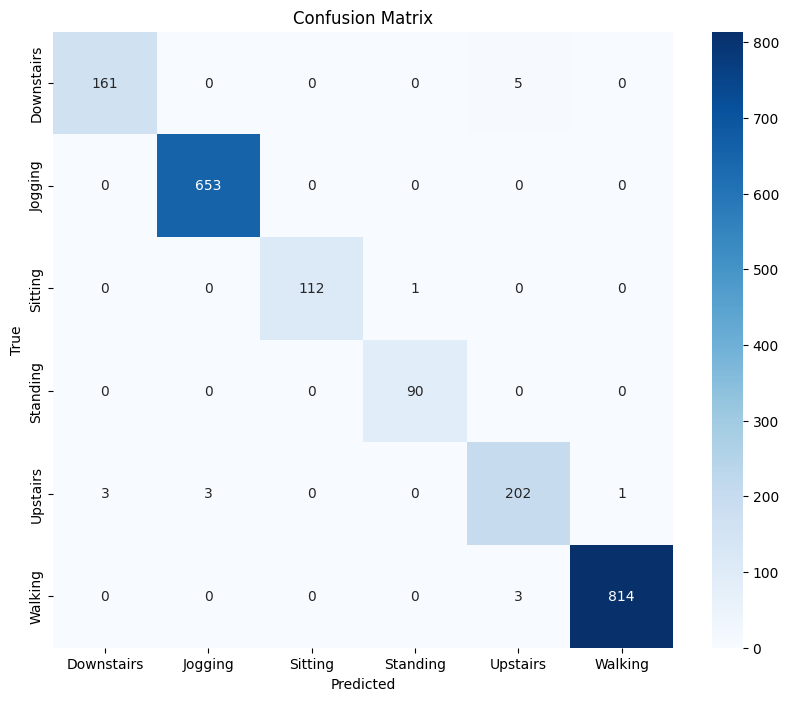

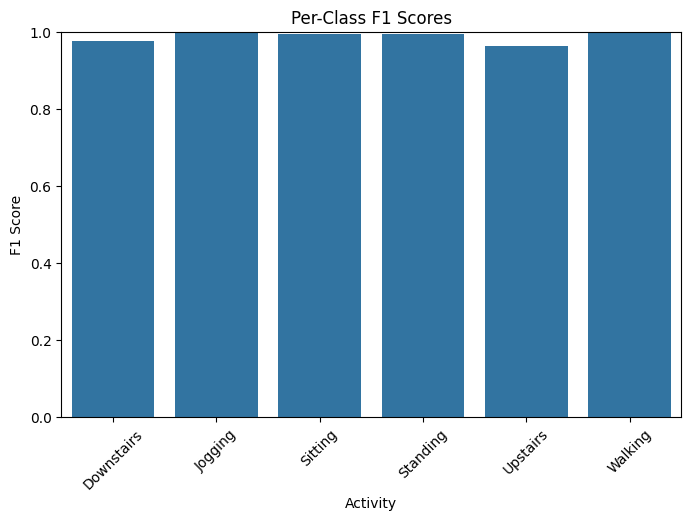

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(f"{SAVE_DIR}/reports/confusion_matrix.png", dpi=300)
plt.show()

# Per-class F1
per_class_f1 = f1_score(y_test, y_pred, average=None)
df_f1 = pd.DataFrame({"Activity": le.classes_, "F1 Score": per_class_f1})
df_f1.to_csv(f"{SAVE_DIR}/reports/per_class_f1.csv", index=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Activity", y="F1 Score", data=df_f1)
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.title("Per-Class F1 Scores")
plt.savefig(f"{SAVE_DIR}/reports/f1_scores.png", dpi=300)
plt.show()

In [19]:
import pandas as pd

df_preds = pd.DataFrame({
    "y_true": le.inverse_transform(y_test),
    "y_pred": le.inverse_transform(y_pred),
    "confidence": y_pred_probs.max(axis=1)
})
df_preds.to_csv(f"{SAVE_DIR}/reports/predictions_test.csv", index=False)

In [20]:
# ==============================
# STAGE 5.1-extra: Metrics Summary Table → CSV, Markdown, LaTeX
# ==============================
import os, pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

os.makedirs(f"{SAVE_DIR}/reports", exist_ok=True)

# --- Compute metrics ---
metrics = {
    "Accuracy":                accuracy_score(y_test, y_pred),
    "Precision (Macro)":       precision_score(y_test, y_pred, average="macro", zero_division=0),
    "Recall (Macro)":          recall_score(y_test, y_pred, average="macro", zero_division=0),
    "F1 (Macro)":              f1_score(y_test, y_pred, average="macro", zero_division=0),
    "Precision (Weighted)":    precision_score(y_test, y_pred, average="weighted", zero_division=0),
    "Recall (Weighted)":       recall_score(y_test, y_pred, average="weighted", zero_division=0),
    "F1 (Weighted)":           f1_score(y_test, y_pred, average="weighted", zero_division=0),
}

df_metrics = (
    pd.DataFrame(metrics, index=["Value"])
      .T.reset_index()
      .rename(columns={"index":"Metric", "Value":"Score"})
)
df_metrics["Score"] = df_metrics["Score"].round(4)

# --- Save CSV ---
csv_path = f"{SAVE_DIR}/reports/metrics_summary_test.csv"
df_metrics.to_csv(csv_path, index=False)

# --- Save Markdown (for README / docs) ---
md_path = f"{SAVE_DIR}/reports/metrics_summary_test.md"
with open(md_path, "w") as f:
    f.write("| Metric | Score |\n|---|---|\n")
    for _, r in df_metrics.iterrows():
        f.write(f"| {r['Metric']} | {r['Score']:.4f} |\n")

# --- Save LaTeX (Overleaf ready) ---
latex_path = f"{SAVE_DIR}/reports/metrics_summary_test.tex"
latex_table = r"""
\begin{table}[h]
\centering
\caption{Test Metrics Summary}
\label{tab:test_metrics_summary}
\begin{tabular}{lc}
\toprule
\textbf{Metric} & \textbf{Score} \\
\midrule
"""[1:]  # strip leading newline

for _, r in df_metrics.iterrows():
    latex_table += f"{r['Metric']} & {r['Score']:.4f} \\\\\n"

latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# ensure booktabs hint
with open(latex_path, "w") as f:
    f.write(latex_table)

print("✅ Saved tables:")
print("-", csv_path)
print("-", md_path)
print("-", latex_path)
print("\n🔎 LaTeX note: add \\usepackage{booktabs} in your preamble for \\toprule/\\midrule/\\bottomrule.")

✅ Saved tables:
- /content/capture24_data/processed/reports/metrics_summary_test.csv
- /content/capture24_data/processed/reports/metrics_summary_test.md
- /content/capture24_data/processed/reports/metrics_summary_test.tex

🔎 LaTeX note: add \usepackage{booktabs} in your preamble for \toprule/\midrule/\bottomrule.


In [21]:
# ==============================
# STAGE 5.1-extra-b: Per-class Metrics → CSV, Markdown, LaTeX
# ==============================
import os, json, pandas as pd
from sklearn.metrics import classification_report

os.makedirs(f"{SAVE_DIR}/reports", exist_ok=True)

# --- Build classification report dict ---
rep = classification_report(
    y_test, y_pred,
    target_names=list(le.classes_),
    output_dict=True,
    zero_division=0
)

# Keep only class rows (exclude 'accuracy','macro avg','weighted avg')
per_class_rows = []
for k, v in rep.items():
    if k in ("accuracy", "macro avg", "weighted avg"):
        continue
    # v is a dict with precision, recall, f1-score, support
    per_class_rows.append({
        "Class": k,
        "Precision": v.get("precision", 0.0),
        "Recall": v.get("recall", 0.0),
        "F1": v.get("f1-score", 0.0),
        "Support": int(v.get("support", 0))
    })

df_pc = pd.DataFrame(per_class_rows)

# Optional: sort by Support (desc) so major classes appear first
df_pc = df_pc.sort_values("Support", ascending=False).reset_index(drop=True)

# Round metrics for presentation
df_pc["Precision"] = df_pc["Precision"].round(4)
df_pc["Recall"]    = df_pc["Recall"].round(4)
df_pc["F1"]        = df_pc["F1"].round(4)

# --- Save CSV ---
csv_path = f"{SAVE_DIR}/reports/per_class_metrics_test.csv"
df_pc.to_csv(csv_path, index=False)

# --- Save Markdown ---
md_path = f"{SAVE_DIR}/reports/per_class_metrics_test.md"
with open(md_path, "w") as f:
    f.write("| Class | Precision | Recall | F1 | Support |\n|---|---:|---:|---:|---:|\n")
    for _, r in df_pc.iterrows():
        f.write(f"| {r['Class']} | {r['Precision']:.4f} | {r['Recall']:.4f} | {r['F1']:.4f} | {r['Support']} |\n")

# --- Save LaTeX (Overleaf-ready; uses booktabs) ---
latex_path = f"{SAVE_DIR}/reports/per_class_metrics_test.tex"
latex_header = r"""
\begin{table}[h]
\centering
\caption{Per-class Precision, Recall, F1, and Support on Test Set}
\label{tab:per_class_metrics_test}
\begin{tabular}{lrrrr}
\toprule
\textbf{Class} & \textbf{Precision} & \textbf{Recall} & \textbf{F1} & \textbf{Support} \\
\midrule
""".lstrip("\n")

latex_rows = ""
for _, r in df_pc.iterrows():
    latex_rows += f"{r['Class']} & {r['Precision']:.4f} & {r['Recall']:.4f} & {r['F1']:.4f} & {int(r['Support'])} \\\\\n"

latex_footer = r"""\bottomrule
\end{tabular}
\end{table}
"""

with open(latex_path, "w") as f:
    f.write(latex_header + latex_rows + latex_footer)

print("✅ Saved per-class tables:")
print("-", csv_path)
print("-", md_path)
print("-", latex_path)
print("\n🔎 LaTeX note: add \\usepackage{booktabs} in your preamble for \\toprule/\\midrule/\\bottomrule.")

✅ Saved per-class tables:
- /content/capture24_data/processed/reports/per_class_metrics_test.csv
- /content/capture24_data/processed/reports/per_class_metrics_test.md
- /content/capture24_data/processed/reports/per_class_metrics_test.tex

🔎 LaTeX note: add \usepackage{booktabs} in your preamble for \toprule/\midrule/\bottomrule.


Save channel stats from training (for correct scaling at inference)

In [22]:
# Save per-channel mean/std from your training set for use in the app
import os, json, numpy as np

SAVE_DIR = "/content/capture24_data/processed"  # adjust if different
X_train = np.load(os.path.join(SAVE_DIR, "X_train.npy"))  # (N, window, 3)

# mean/std over all windows & timesteps for each channel
mean = X_train.mean(axis=(0,1)).tolist()  # [mx, my, mz]
std  = X_train.std(axis=(0,1)).tolist()   # [sx, sy, sz]

with open(os.path.join(SAVE_DIR, "channel_stats.json"), "w") as f:
    json.dump({"mean": mean, "std": std}, f, indent=2)

print("Saved channel stats to:", os.path.join(SAVE_DIR, "channel_stats.json"))


Saved channel stats to: /content/capture24_data/processed/channel_stats.json


Step 1 — Create

In [23]:
%%writefile app.py
import os, io, re, json, pickle, time
import numpy as np
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# ---------- Paths (adjust if needed) ----------
BASE = "/content/capture24_data/processed"
MODEL_PATH = os.path.join(BASE, "cnn_bilstm_best.h5")
ENCODER_PATH = os.path.join(BASE, "label_encoder.pkl")
STATS_PATH = os.path.join(BASE, "channel_stats.json")

# ---------- Helpers ----------
def to_numeric_strict(series: pd.Series):
    s = series.astype(str).str.replace(r'[^0-9eE\-\.+]', '', regex=True)
    return pd.to_numeric(s, errors="coerce")

def standardize_xyz(df, stats):
    means = np.array(stats["mean"])
    stds  = np.array(stats["std"])
    xyz = df[["x","y","z"]].values.astype("float32")
    stds = np.where(stds == 0, 1.0, stds)
    xyz = (xyz - means) / stds
    df_scaled = df.copy()
    df_scaled[["x","y","z"]] = xyz
    return df_scaled

def create_windows_xyz(df, window_size=200, step=100):
    X = []
    meta = []
    vals = df[["x","y","z"]].values
    times = df["timestamp"].values if "timestamp" in df.columns else np.arange(len(df))
    labels = df["activity"].values if "activity" in df.columns else None
    n = len(df)
    for start in range(0, n - window_size + 1, step):
        end = start + window_size
        X.append(vals[start:end])
        meta.append({
            "start_idx": start,
            "end_idx": end,
            "start_time": float(times[start]),
            "end_time": float(times[end-1]),
            "true_label": None if labels is None else str(pd.Series(labels[start:end]).mode().iloc[0])
        })
    X = np.asarray(X, dtype="float32")
    meta = pd.DataFrame(meta)
    return X, meta

def plot_timeline(meta_df, pred_labels):
    # Simple timeline over windows
    fig, ax = plt.subplots(figsize=(10, 2.8))
    t = np.arange(len(pred_labels))
    ax.step(t, pred_labels, where='post')
    ax.set_xlabel("Window index")
    ax.set_ylabel("Predicted label (index)")
    ax.set_title("Prediction Timeline (by window)")
    plt.tight_layout()
    return fig

# ---------- Load artefacts ----------
@st.cache_resource
def load_artefacts():
    model = load_model(MODEL_PATH)
    with open(ENCODER_PATH, "rb") as f:
        le = pickle.load(f)
    with open(STATS_PATH, "r") as f:
        stats = json.load(f)
    return model, le, stats

# ---------- UI ----------
st.set_page_config(page_title="WISDM Activity Recognition", layout="wide")
st.title("📊 WISDM Activity Recognition — Streamlit Demo")
st.caption("Upload a WISDM CSV/TXT (columns: user, activity (optional), timestamp, x, y, z). The app windows, scales, predicts, and visualizes results.")

model, le, stats = load_artefacts()
classes = list(le.classes_)

with st.sidebar:
    st.header("Settings")
    window_size = st.slider("Window size", 50, 400, 200, 10)
    overlap = st.slider("Overlap (%)", 0, 90, 50, 5)
    step = max(1, int(window_size * (1 - overlap / 100)))
    max_rows = st.number_input("Max rows to read (for speed)", 5000, 5000000, 200000, step=5000)
    st.write(f"Step = {step}")

uploaded = st.file_uploader("Upload WISDM file (.csv or .txt)", type=["csv", "txt"])

if uploaded is None:
    st.info("⬆️ Upload a file to begin.")
    st.stop()

# ---------- Read & clean ----------
try:
    df = pd.read_csv(uploaded, header=None, names=['user','activity','timestamp','x','y','z'], sep=",", on_bad_lines="skip")
except Exception:
    uploaded.seek(0)
    df = pd.read_csv(uploaded, header=None, names=['user','activity','timestamp','x','y','z'], delim_whitespace=True, on_bad_lines="skip")

# Limit for speed
df = df.head(int(max_rows))

# Clean numeric cols
for c in ["timestamp","x","y","z"]:
    df[c] = to_numeric_strict(df[c])
# Clean string cols
df["activity"] = df["activity"].astype(str).str.strip()
df = df.dropna(subset=["x","y","z"]).reset_index(drop=True)

st.success(f"Loaded data: {df.shape[0]:,} rows")
st.dataframe(df.head(10), use_container_width=True)

# ---------- Standardize & window ----------
df_scaled = standardize_xyz(df, stats)
X, meta = create_windows_xyz(df_scaled, window_size=window_size, step=step)

if len(X) == 0:
    st.error("Not enough rows to form any window. Reduce window size or upload a longer file.")
    st.stop()

st.write(f"Windows created: **{len(X)}**  (shape: {X.shape})")

# ---------- Predict ----------
probs = model.predict(X, verbose=0)
y_pred = probs.argmax(axis=1)
pred_labels = [classes[i] for i in y_pred]

# ---------- Visuals: counts + timeline ----------
col1, col2 = st.columns([1,1])
with col1:
    st.subheader("Predicted class distribution")
    counts = pd.Series(pred_labels).value_counts().rename_axis("Activity").reset_index(name="Count")
    st.bar_chart(counts.set_index("Activity"))

with col2:
    st.subheader("Timeline (window-level)")
    # map labels to indices for plotting
    label_to_idx = {c:i for i,c in enumerate(classes)}
    fig = plot_timeline(meta, [label_to_idx[l] for l in pred_labels])
    st.pyplot(fig)

# ---------- Optional evaluation if ground-truth activity exists ----------
if "activity" in df.columns and df["activity"].notna().any():
    if meta["true_label"].notna().any():
        y_true_win = meta["true_label"].fillna("UNKNOWN").values
        # Only compare where labels are from known classes
        mask = np.isin(y_true_win, classes)
        y_true_enc = [classes.index(l) if l in classes else -1 for l in y_true_win[mask]]
        y_pred_enc = y_pred[mask]

        if len(y_true_enc) > 0:
            st.subheader("Evaluation (if activity present in file)")
            # Confusion matrix
            cm = confusion_matrix(y_true_enc, y_pred_enc, labels=range(len(classes)))
            fig2, ax2 = plt.subplots(figsize=(min(12, 0.7*len(classes)+3), min(10, 0.7*len(classes)+3)))
            im = ax2.imshow(cm, cmap="Blues")
            ax2.set_xticks(range(len(classes))); ax2.set_yticks(range(len(classes)))
            ax2.set_xticklabels(classes, rotation=45, ha="right"); ax2.set_yticklabels(classes)
            ax2.set_xlabel("Predicted"); ax2.set_ylabel("True"); ax2.set_title("Confusion Matrix (window-level)")
            plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
            plt.tight_layout()
            st.pyplot(fig2)

            # Classification report
            rep = classification_report(y_true_enc, y_pred_enc, target_names=classes, zero_division=0, output_dict=False)
            st.text(rep)
        else:
            st.info("Ground truth activities in this file are not aligned with trained classes; skipping evaluation.")

# ---------- Download predictions ----------
out = meta.copy()
out["pred_label"] = pred_labels
out["top1_prob"] = probs.max(axis=1)
csv_bytes = out.to_csv(index=False).encode("utf-8")
st.download_button("⬇️ Download window-level predictions CSV", data=csv_bytes, file_name="predictions_window_level.csv", mime="text/csv")

st.caption("Tip: include a small segment of the original WISDM file to keep the app responsive.")

Writing app.py


Step 2 — Run the app

In [25]:
!pip -q install streamlit==1.37.0
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O cloudflared
!chmod +x cloudflared
# Start Streamlit
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0 &>/content/app.log &
# Expose a public URL
!./cloudflared tunnel --url http://127.0.0.1:8501 --no-autoupdate


2025-09-28T13:31:31Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-09-28T13:31:31Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-09-28T13:31:36Z INF +--------------------------------------------------------------------------------------------+
2025-09-28T13:31:36Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-09-28T13:31:36Z INF |  https://assigned-careers-formed-convert.trycloudflare